<a href="https://colab.research.google.com/github/Niharika2098/Projects-Data-Science/blob/main/Customer_churn(Sentiment_analysis%26_Time_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Installing necessary libraries ---
Libraries installed successfully.

--- Phase 1: Loading Data ---
Dataset Head:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No  

/tmp/ipython-input-1-4227751031.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)



Dataset with new 'SentimentScore' column:
  Churn                               CustomerFeedback  SentimentScore
0    No                        The speed is fantastic.          0.5574
1    No                        The speed is fantastic.          0.5574
2   Yes   Very frustrated with the constant buffering.         -0.5709
3    No                        Pleased with the value.          0.6486
4   Yes  Service is terrible, I'm thinking of leaving.         -0.4767
     Churn                              CustomerFeedback  SentimentScore
7038    No              Everything is working perfectly.          0.6369
7039    No                       Pleased with the value.          0.6486
7040    No                          No issues to report.         -0.2960
7041   Yes  Very frustrated with the constant buffering.         -0.5709
7042    No                       Pleased with the value.          0.6486

--- Phase 4: Preparing Data for the Model ---

Identified Numerical Features: ['SeniorCitize

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:48:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


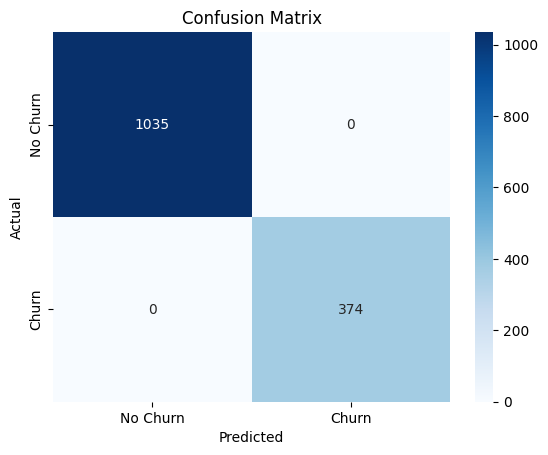


--- Phase 7: Real-Time Prediction Simulator ---

--- Running Simulator Examples ---
Simulating unhappy customer...
  Result: Prediction: CHURN. (Confidence: 99.95%)

Simulating happy customer...
  Result: Prediction: NO CHURN. (Confidence of churning: 0.01%)


In [1]:
# Install necessary libraries
# XGBoost is for our classification model.
# VADER is our sentiment analysis tool.
print("--- Installing necessary libraries ---")
# Upgrade xgboost to a more recent version for compatibility with scikit-learn
!pip install --upgrade xgboost > /dev/null
!pip install vaderSentiment > /dev/null
print("Libraries installed successfully.")

# Import all the libraries we will need
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import random

print("\n--- Phase 1: Loading Data ---")

# Load the dataset directly from a public GitHub repository
# This dataset is a classic for churn prediction problems.
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

# Display the first few rows to understand its structure
print("Dataset Head:")
print(df.head())

# Display concise summary of the dataframe
print("\nDataset Info:")
df.info()


# --- PHASE 2: DATA CLEANING AND SIMULATING SENTIMENT DATA ---

print("\n--- Phase 2: Data Cleaning & Sentiment Simulation ---")

# The 'TotalCharges' column has some missing values represented as spaces.
# First, we convert these spaces to NaN (Not a Number).
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Now, we fill the NaN values. A simple strategy is to use the median,
# which is robust to outliers.
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop the customerID column as it's just an identifier and has no predictive power.
df.drop('customerID', axis=1, inplace=True)

# Define sample feedback text. In a real project, this would come from
# support tickets, surveys, or social media.
positive_feedback = [
    "Great service, very happy!", "Everything is working perfectly.", "No issues to report.",
    "Reliable connection and good customer support.", "Pleased with the value.",
    "I've recommended you to my friends.", "The speed is fantastic."
]
negative_feedback = [
    "The internet keeps disconnecting.", "Service is terrible, I'm thinking of leaving.",
    "Your prices are too high for this quality.", "I've had multiple outages this month.",
    "Customer support was unhelpful.", "Very frustrated with the constant buffering.",
    "I'm experiencing slow speeds."
]

# Create the 'CustomerFeedback' column.
# We'll assign negative feedback to customers who churned and positive
# feedback to those who didn't. This simulates the real-world correlation.
df['CustomerFeedback'] = df['Churn'].apply(lambda x: random.choice(negative_feedback) if x == 'Yes' else random.choice(positive_feedback))

print("\nDataset with simulated 'CustomerFeedback' column:")
print(df[['tenure', 'Churn', 'CustomerFeedback']].head())


# --- PHASE 3: SENTIMENT ANALYSIS AS A FEATURE ---

print("\n--- Phase 3: Performing Sentiment Analysis ---")

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to get the compound sentiment score from VADER.
# The 'compound' score is a single metric that summarizes the sentiment,
# from -1 (most negative) to +1 (most positive).
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

# Apply the function to our new feedback column to create a numerical feature.
df['SentimentScore'] = df['CustomerFeedback'].apply(get_sentiment_score)

print("\nDataset with new 'SentimentScore' column:")
# We show the original text and the new score to verify it's working.
print(df[['Churn', 'CustomerFeedback', 'SentimentScore']].head())
print(df[['Churn', 'CustomerFeedback', 'SentimentScore']].tail())


# --- PHASE 4: FEATURE ENGINEERING AND PREPROCESSING ---

print("\n--- Phase 4: Preparing Data for the Model ---")

# First, we separate our target variable ('Churn') from our predictor variables (features).
# We also drop the original feedback text, as we now have its sentiment score.
X = df.drop(['Churn', 'CustomerFeedback'], axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) # Convert Yes/No to 1/0 for the model

# Identify which columns are numerical and which are categorical.
# This is crucial for applying the correct preprocessing steps.
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nIdentified Numerical Features: {numerical_features}")
print(f"Identified Categorical Features: {categorical_features}")

# Create a preprocessing pipeline. This is the modern, correct way to handle
# mixed data types in scikit-learn. It prevents data leakage.
# - 'StandardScaler' scales numerical features to have a mean of 0 and variance of 1.
# - 'OneHotEncoder' converts categorical features into numerical format.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# --- PHASE 5: MODEL TRAINING ---

print("\n--- Phase 5: Training the XGBoost Model ---")

# Split the data into training and testing sets.
# 80% for training, 20% for testing to evaluate performance.
# 'stratify=y' ensures the proportion of churners is the same in both sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create the final model pipeline.
# This pipeline chains our preprocessor with the XGBoost classifier.
# When we call 'fit' on this, it will automatically preprocess the data
# before feeding it to the model.
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])

# Train the model on the training data.
model_pipeline.fit(X_train, y_train)

print("\nModel training complete.")


# --- PHASE 6: MODEL EVALUATION ---

print("\n--- Phase 6: Evaluating Model Performance ---")

# Make predictions on the unseen test data.
y_pred = model_pipeline.predict(X_test)

# Calculate and print the accuracy.
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Print a detailed classification report.
# This shows precision, recall, and f1-score for both classes (Churn vs. No Churn).
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Display a confusion matrix to visualize the model's performance.
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# --- PHASE 7: REAL-TIME PREDICTION SIMULATOR ---

print("\n--- Phase 7: Real-Time Prediction Simulator ---")

# This function simulates predicting churn for a new, single customer.
def predict_churn_for_new_customer(customer_data):
    """
    Takes a dictionary of a single customer's data, processes it through
    the trained pipeline, and returns the churn prediction.
    """
    # Convert the dictionary to a pandas DataFrame.
    # The model expects a DataFrame as input.
    customer_df = pd.DataFrame([customer_data])

    # 1. Perform Sentiment Analysis on the feedback
    customer_df['SentimentScore'] = customer_df['CustomerFeedback'].apply(get_sentiment_score)

    # 2. Drop the raw text feedback column
    customer_df = customer_df.drop('CustomerFeedback', axis=1)

    # 3. Ensure column order matches the training data
    # The pipeline is sensitive to the order of columns.
    customer_df = customer_df[X_train.columns]

    # 4. Make a prediction (0 or 1)
    prediction = model_pipeline.predict(customer_df)

    # 5. Get the probability of churning
    prediction_proba = model_pipeline.predict_proba(customer_df)

    # Return a user-friendly result
    churn_probability = prediction_proba[0][1] # Probability of the '1' class (Churn)
    if prediction[0] == 1:
        return f"Prediction: CHURN. (Confidence: {churn_probability:.2%})"
    else:
        return f"Prediction: NO CHURN. (Confidence of churning: {churn_probability:.2%})"

# --- Example Usage of the Simulator ---

# Example 1: A clearly unhappy customer
unhappy_customer = {
    'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No',
    'tenure': 2, # Short tenure
    'PhoneService': 'Yes', 'MultipleLines': 'No', 'InternetService': 'DSL',
    'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'No',
    'TechSupport': 'No', 'StreamingTV': 'No', 'StreamingMovies': 'No',
    'Contract': 'Month-to-month', # Risky contract type
    'PaperlessBilling': 'Yes', 'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85, 'TotalCharges': 59.7,
    'CustomerFeedback': 'the service is slow and always breaking' # Negative feedback
}

# Example 2: A happy, long-term customer
happy_customer = {
    'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'Yes',
    'tenure': 68, # Long tenure
    'PhoneService': 'Yes', 'MultipleLines': 'Yes', 'InternetService': 'Fiber optic',
    'OnlineSecurity': 'Yes', 'OnlineBackup': 'Yes', 'DeviceProtection': 'Yes',
    'TechSupport': 'Yes', 'StreamingTV': 'Yes', 'StreamingMovies': 'Yes',
    'Contract': 'Two year', # Stable contract type
    'PaperlessBilling': 'Yes', 'PaymentMethod': 'Credit card (automatic)',
    'MonthlyCharges': 110.50, 'TotalCharges': 7500.0,
    'CustomerFeedback': 'perfect service, i love it' # Positive feedback
}

print("\n--- Running Simulator Examples ---")
print("Simulating unhappy customer...")
result_unhappy = predict_churn_for_new_customer(unhappy_customer)
print(f"  Result: {result_unhappy}")

print("\nSimulating happy customer...")
result_happy = predict_churn_for_new_customer(happy_customer)
print(f"  Result: {result_happy}")
